In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import time
import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.NVP import NVP
from Probability.Distributions import RotatedBanana

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double moon distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 4 different 'modes'. 

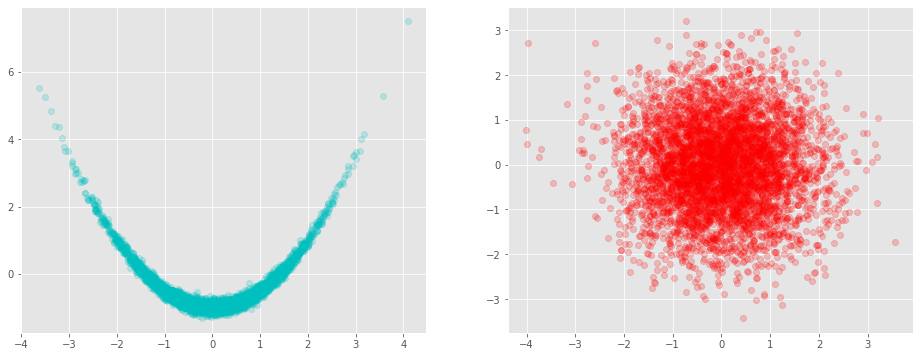

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target = RotatedBanana(num_samples, 0.0, start_height = -1)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [3]:
# Create model object
nvp = NVP(num_layers=4, neuron_list=[200,200])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

In [4]:
# Define training options
n_epochs = 200
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 2.3254
Epoch 2/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 2.1529
Epoch 3/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 2.0579
Epoch 4/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.9493
Epoch 5/200
100/100 [==============================] - 1s 9ms/step - Negative Log Likelihood: 1.8424
Epoch 6/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.7137
Epoch 7/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.5579
Epoch 8/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.4288
Epoch 9/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.3086
Epoch 10/200
100/100 [==============================] - 1s 9ms/step - Negative Log Likeliho

100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.6270
Epoch 82/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.6265
Epoch 83/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.6333
Epoch 84/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.6222
Epoch 85/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.6222
Epoch 86/200
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.6223
Epoch 87/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.6239
Epoch 88/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.6197
Epoch 89/200
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.6198
Epoch 90/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 

100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5610
Epoch 161/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5595
Epoch 162/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5531
Epoch 163/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5564
Epoch 164/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5581
Epoch 165/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5571
Epoch 166/200
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5581
Epoch 167/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5551
Epoch 168/200
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.5525
Epoch 169/200
100/100 [==============================] - 1s 6ms/step - Negative Log Lik

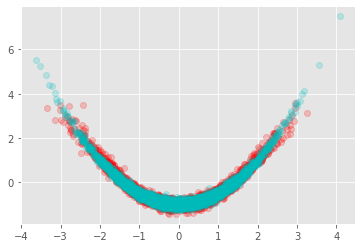

In [5]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

## Conditional Sampling using Metropolis Hastings

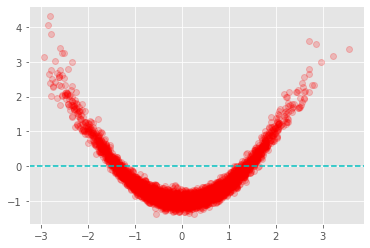

In [6]:
# We want to draw condition samples from about y = 0.0
y_star = 0.0

forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.axhline(y=y_star, color='c', linestyle='--')

In [7]:
# First, we define the function that gives the log prob at a point
def log_c_target(x1, x2 = y_star):
    x = tf.constant([x1,x2],shape=[1,2])
    #log of probability density at that point
    return nvp.log_prob(x)

# Next, the Metropolis hastings algorithm
def MCMC(niters=3000,b=2,init_val=0.0):
    # niters: number of interations of MCMC
    # b: variance of the proposal Gaussian density for X1
    
    naccept=0
    theta = init_val # initial value for the Markov chain

    samples = np.zeros(niters+1)
    samples[0] = theta
    t0 = time.time()
    for i in range(niters):
        theta_p = theta + np.random.randn()*b;
        rho = min(1, tf.math.exp(log_c_target(theta_p)-log_c_target(theta)))
        u = np.random.uniform()
        if u < rho:
            naccept += 1
            theta = theta_p
        samples[i+1] = theta
        if i % 100 == 0:
            t1 = time.time()
            print('it:',i,'time:',t1-t0)
            t0 = t1
    acceptance_rate = naccept/niters
    
    return acceptance_rate, samples

In [8]:
# Run the algorithm
acc_rate, samples = MCMC()

it: 0 time: 1.252971887588501
it: 100 time: 0.2667558193206787
it: 200 time: 0.3574972152709961
it: 300 time: 0.31982874870300293
it: 400 time: 0.3227345943450928
it: 500 time: 0.3269941806793213
it: 600 time: 0.3523266315460205
it: 700 time: 0.3508734703063965
it: 800 time: 0.3455088138580322
it: 900 time: 0.3238241672515869
it: 1000 time: 0.3450472354888916
it: 1100 time: 0.35904645919799805
it: 1200 time: 0.32828187942504883
it: 1300 time: 0.3128368854522705
it: 1400 time: 0.3294973373413086
it: 1500 time: 0.34669041633605957
it: 1600 time: 0.36980724334716797
it: 1700 time: 0.3196556568145752
it: 1800 time: 0.3253445625305176
it: 1900 time: 0.34050655364990234
it: 2000 time: 0.35767030715942383
it: 2100 time: 0.32964086532592773
it: 2200 time: 0.34604382514953613
it: 2300 time: 0.29593825340270996
it: 2400 time: 0.2432692050933838
it: 2500 time: 0.258725643157959
it: 2600 time: 0.24056220054626465
it: 2700 time: 0.21924114227294922
it: 2800 time: 0.21505498886108398
it: 2900 time: 

[(-3.0, 3.0)]

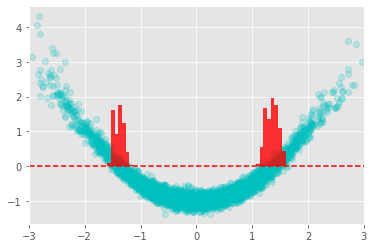

In [9]:
fig, ax = plt.subplots()
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'co', alpha=.2)
ax.hist(samples, 150, (-5, 5), color='r', alpha=.8, density=True, zorder=10)
ax.axhline(y=y_star, color='r', linestyle='--')
ax.set(xlim=(-3, 3))

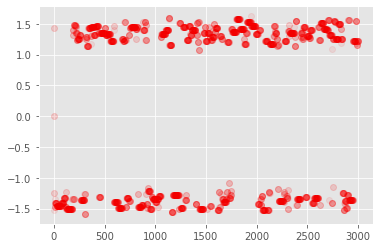

In [10]:
plt.plot(samples, 'ro', alpha = .075)